# Подготовка сырого датасета для классификации
1. Базовый анализ
2. Сбор таблицы на основе .set файлов
3. Получение базовый статистики
4. Фильтрация
5. Разбиение на train/valid

In [1]:
import glob

import mne
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

## Подготовка метадаты
Парсим датасет, делаем таблицу с полями

In [2]:
eeg_files = glob.glob('/Users/whatislove/study/phd/data/eegs_classification/*/*.set')
df_eegs = pd.DataFrame(eeg_files, columns=['path'])

df_eegs['session_type'] = df_eegs['path'].apply(lambda x: x.split('/')[-2])
df_eegs['mono'] = df_eegs['path'].apply(lambda x: 'mono' in x.split('/')[-1])
df_eegs['subject_id'] = df_eegs['path'].apply(lambda x: '_'.join(x.split('/')[-1].replace('_mono', '').split('_')[:3]))

In [3]:
df_eegs.shape[0], df_eegs.session_type.value_counts(), df_eegs.subject_id.nunique()

(96,
 session_type
 other    32
 fon      32
 own      32
 Name: count, dtype: int64,
 32)

## Подготовка метадаты
Чтение и сохранение метадаты из ЭЭГ (аннотации, длительность и тд)

In [4]:
# игнор известных ворнингов

import warnings
import sys
import os

# Suppress warnings from Python, numpy, and C-level (including joblib workers)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.environ["PYTHONWARNINGS"] = "ignore"
if hasattr(sys, 'warnoptions'):
    sys.warnoptions = []

def block_warnings_in_worker():
    import warnings, os
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    os.environ["PYTHONWARNINGS"] = "ignore"

# Patch: run warning suppression inside the function/context run by joblib
from functools import wraps

def suppress_worker_warnings(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        block_warnings_in_worker()
        return func(*args, **kwargs)
    return wrapper

In [5]:
def extract_ann_info(path: str) -> dict:
    """
    Load a .set file, return dict with path, total duration (s), ann.onset, ann.description,
    and additional metadata such as sfreq and channel list.
    """
    try:
        raw = mne.io.read_raw_eeglab(path, preload=True, verbose=False)
        n_samples = raw.n_times
        sfreq = raw.info["sfreq"]
        duration_sec = n_samples / sfreq
        ann = raw.annotations

        # cast onset and description to Python list for DataFrame compatibility
        onset_list = ann.onset.tolist()
        description_list = list(ann.description)
        ch_names = list(raw.info['ch_names'])
        n_channels = len(ch_names)
        meas_date = raw.info.get('meas_date', None)
        if meas_date is not None:
            # meas_date can be a tuple or Timestamp, handle gracefully
            try:
                if hasattr(meas_date, 'isoformat'):
                    meas_date_str = meas_date.isoformat()
                elif isinstance(meas_date, (tuple, list)) and len(meas_date) > 0:
                    meas_date_str = str(meas_date)
                else:
                    meas_date_str = str(meas_date)
            except Exception:
                meas_date_str = str(meas_date)
        else:
            meas_date_str = None

        return {
            'path': path,
            'duration_sec': duration_sec,
            'ann_onset': onset_list,
            'ann_description': description_list,
            'sfreq': sfreq,
            'ch_names': ch_names,
            'n_channels': n_channels,
            'meas_date': meas_date_str
        }
    except Exception as e:
        return {
            'path': path,
            'duration_sec': None,
            'ann_onset': None,
            'ann_description': None,
            'sfreq': None,
            'ch_names': None,
            'n_channels': None,
            'meas_date': None,
            'error': str(e)
        }

In [6]:
records = Parallel(n_jobs=4, verbose=1)(
    delayed(suppress_worker_warnings(extract_ann_info))(path)
    for path in tqdm(df_eegs['path'], desc="Reading EEGs with ann info")
)

df_ann_info = pd.DataFrame(records)
df_eegs = df_eegs.merge(df_ann_info, how='left', on='path')

Reading EEGs with ann info: 100%|██████████| 96/96 [00:32<00:00,  2.94it/s]
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:   36.3s finished


## Обработка аннотаций

In [7]:
import re

def normalize_ann_descriptions(desc_list):
    if desc_list is None:
        return desc_list
    return [
        re.sub(r'\bS\s*1\b', 'S1', re.sub(r'\bS\s*2\b', 'S2', desc))
        if isinstance(desc, str) else desc
        for desc in desc_list
    ]

df_eegs['ann_description'] = df_eegs['ann_description'].apply(normalize_ann_descriptions)

In [8]:
def get_segments_S(row, which):
    segs = []
    ann_desc = row['ann_description']
    seg_starts = row['all_segments']
    pattern = r"S\s*{}".format(which)
    for i, desc in enumerate(ann_desc):
        if re.fullmatch(pattern, desc) or desc == f"S{which}":
            segs.append((seg_starts[i], seg_starts[i + 1]))
    return segs

df_eegs['all_segments'] = df_eegs.apply(lambda row: [float(seg_start) for seg_start in row['ann_onset']] + [float(row['duration_sec'])], axis=1)
df_eegs['segment_durations'] = df_eegs['all_segments'].apply(lambda x: [round(float(x[i + 1]) - float(x[i]), 2) for i in range(len(x) - 1)])

# select segments with S1 and S2 annotations
df_eegs['segments_S1'] = df_eegs.apply(lambda row: get_segments_S(row, 1), axis=1)
df_eegs['segments_S2'] = df_eegs.apply(lambda row: get_segments_S(row, 2), axis=1)

In [9]:
# segment lengths statistics
s1_lengths = []
s2_lengths = []

for idx, row in df_eegs.iterrows():
    for seg in row['segments_S1']:
        s1_lengths.append(seg[1] - seg[0])
    for seg in row['segments_S2']:
        s2_lengths.append(seg[1] - seg[0])


print("S1 segment lengths:")
print("  count:", len(s1_lengths))
print("  mean:", np.mean(s1_lengths) if s1_lengths else None)
print("  std:", np.std(s1_lengths) if s1_lengths else None)
print("  min:", np.min(s1_lengths) if s1_lengths else None)
print("  max:", np.max(s1_lengths) if s1_lengths else None)

print("\nS2 segment lengths:")
print("  count:", len(s2_lengths))
print("  mean:", np.mean(s2_lengths) if s2_lengths else None)
print("  std:", np.std(s2_lengths) if s2_lengths else None)
print("  min:", np.min(s2_lengths) if s2_lengths else None)
print("  max:", np.max(s2_lengths) if s2_lengths else None)


S1 segment lengths:
  count: 284
  mean: 97.50909507042253
  std: 29.5183666759581
  min: 0.515500000000003
  max: 133.0

S2 segment lengths:
  count: 286
  mean: 87.31186713286714
  std: 42.84767029017194
  min: 0.1705000000000041
  max: 352.0


In [10]:
min_segment_len = 50
max_segment_len = 180

def flag_good_segments(segments, min_len, max_len):
    return [(min_len < (seg[1] - seg[0]) < max_len) for seg in segments]

df_eegs['good_S1'] = df_eegs['segments_S1'].apply(lambda segs: flag_good_segments(segs, min_segment_len, max_segment_len))
df_eegs['good_S2'] = df_eegs['segments_S2'].apply(lambda segs: flag_good_segments(segs, min_segment_len, max_segment_len))
df_eegs['all_good_S1'] = df_eegs['good_S1'].apply(lambda flags: all(flags) if len(flags) > 0 else False)
df_eegs['all_good_S2'] = df_eegs['good_S2'].apply(lambda flags: all(flags) if len(flags) > 0 else False)
df_eegs['good_segments'] = df_eegs['all_good_S1'] & df_eegs['all_good_S2']


In [11]:
(df_eegs.all_good_S1.value_counts(),
df_eegs.all_good_S2.value_counts(),
df_eegs.good_segments.value_counts())

(all_good_S1
 True     77
 False    19
 Name: count, dtype: int64,
 all_good_S2
 True     61
 False    35
 Name: count, dtype: int64,
 good_segments
 True     58
 False    38
 Name: count, dtype: int64)

In [12]:
# Статистика по good_segments в разрезе session_type. Разницы нет

print("Статистика по good_segments в разрезе session_type:")
print(df_eegs.groupby('session_type')['good_segments'].value_counts().unstack(fill_value=0))

print("\nДоля хороших (good_segments=True) в разрезе session_type:")
print(df_eegs.groupby('session_type')['good_segments'].mean())


Статистика по good_segments в разрезе session_type:
good_segments  False  True 
session_type               
fon               13     19
other             11     21
own               14     18

Доля хороших (good_segments=True) в разрезе session_type:
session_type
fon      0.59375
other    0.65625
own      0.56250
Name: good_segments, dtype: float64


In [13]:
# # Посмотрим, какие subject_id дают плохие сегменты чаще других

# bad_subjects = df_eegs.loc[~df_eegs['good_segments'], 'subject_id'].value_counts()
# good_subjects = df_eegs.loc[df_eegs['good_segments'], 'subject_id'].value_counts()

# subject_stats = pd.DataFrame({
#     'bad_count': bad_subjects,
#     'good_count': good_subjects
# }).fillna(0).astype(int)

# subject_stats['bad_fraction'] = subject_stats['bad_count'] / (subject_stats['bad_count'] + subject_stats['good_count'])

# print(subject_stats.sort_values('bad_fraction', ascending=False))

## Фильтрация записей

In [14]:
df_eegs = df_eegs[(df_eegs['all_good_S1'] == True) | (df_eegs['all_good_S2'] == True)].reset_index(drop=True)

## Разделение выборки на train/test

In [15]:
# делим на train/valid 80/20 со сплитом по subject_id
from sklearn.model_selection import train_test_split

# Получаем уникальные subject_id
subject_ids = df_eegs['subject_id'].unique()
train_ids, valid_ids = train_test_split(subject_ids, test_size=0.2, random_state=69)

df_eegs['split'] = df_eegs['subject_id'].apply(lambda x: 'train' if x in train_ids else 'valid')

In [16]:
df_eegs.to_parquet('../../data/classification/raw/segments_split_v1.parquet', index=False)

In [3]:
df_eegs = pd.read_parquet('../../data/classification/raw/segments_split_v1.parquet')

In [ ]:
## Сегменты
# Make frame where each row is a S1 or S2 segment (with label and EEG metadata)

segment_rows = []

for idx, row in df_eegs.iterrows():
    # S1 segments
    for seg in row.get('segments_S1', []):
        segment_rows.append({
            'path': row['path'],
            'session_type': row['session_type'],
            'mono': row['mono'],
            'subject_id': row.get('subject_id', None),
            'duration_sec': row.get('duration_sec', None),
            'good_eeg': row.get('good_eeg', None),
            'segment_type': 'S1',
            'segment_start': seg[0],
            'segment_end': seg[1],
            'segment_len': seg[1] - seg[0],
            'bad_segments_for_eeg': row.get('bad_segments', []),
        })
    # S2 segments
    for seg in row.get('segments_S2', []):
        segment_rows.append({
            'path': row['path'],
            'session_type': row['session_type'],
            'mono': row['mono'],
            'subject_id': row.get('subject_id', None),
            'duration_sec': row.get('duration_sec', None),
            'good_eeg': row.get('good_eeg', None),
            'segment_type': 'S2',
            'segment_start': seg[0],
            'segment_end': seg[1],
            'segment_len': seg[1] - seg[0],
            'bad_segments_for_eeg': row.get('bad_segments', []),
        })

df_segments = pd.DataFrame(segment_rows)

In [ ]:
df_eegs['path'] = df_eegs['path'].apply(lambda x: x.replace('/mnt/d/Study/PhD/Data/EEG/', '/Users/whatislove/study/phd/data/eegs_classification/'))

In [ ]:
df_segments.to_parquet('../data/classification/raw_eegs_segments.parquet')

In [ ]:
df_segments = pd.read_parquet('../data/classification/raw_eegs_segments.parquet')

## Нарезка кропов

In [40]:
import torch
import numpy as np
import pandas as pd

# Загружаем датафрейм с путями к кропам
df = pd.read_parquet('../data/classification/raw_eegs_crops_500_ch_30.parquet')
print("Number of segments:", len(df))
print("First 3 crop paths:\n", df['crop_path'].head(3).tolist())

# Загружаем батч из 128 EEG-кропов
batch_size = 128
batch_paths = df['crop_path'].head(batch_size).tolist()

eeg_segments = []
expected_n_channels = 30
for p in batch_paths:
    d = np.load(p)  # shape: (n_channels, n_samples)
    if d.shape[0] != expected_n_channels:
        raise ValueError(f"Файл {p} имеет {d.shape[0]} каналов вместо 30!")
    eeg_segments.append(d)
eeg_segments = np.stack(eeg_segments)  # (batch_size, 62, n_samples)
print("EEG segments np array shape:", eeg_segments.shape)

# Преобразуем в torch tensor
inputs = torch.from_numpy(eeg_segments.astype(np.float32))  # (batch, 64, samples)
print("Input torch tensor shape:", inputs.shape)

# При необходимости на cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)

n_channels = expected_n_channels
in_samples = inputs.shape[2]
n_classes = 2  # или другое число классов

# Модель EEGNet для 30 каналов
class EEGNet(torch.nn.Module):
    def __init__(self, n_channels=30, in_samples=2500, n_classes=2):
        super(EEGNet, self).__init__()
        # Вход: (batch, 64, samples)
        self.conv1 = torch.nn.Conv1d(n_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = torch.nn.BatchNorm1d(64)
        # groups=64 для depthwise-свёртки
        self.conv2 = torch.nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2, groups=64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = torch.nn.Conv1d(128, 256, kernel_size=1)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.pool = torch.nn.AdaptiveAvgPool1d(32)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(256 * 32, 128)
        self.fc2 = torch.nn.Linear(128, n_classes)
    def forward(self, x):
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EEGNet(n_channels=n_channels, in_samples=in_samples, n_classes=n_classes).to(device)

with torch.no_grad():
    out = model(inputs)
print("Model output shape:", out.shape)

Number of segments: 8780
First 3 crop paths:
 ['/Users/whatislove/study/phd/data/processed_ch_30/Co_y6_003_fon1_S1_41292_46292.npy', '/Users/whatislove/study/phd/data/processed_ch_30/Co_y6_003_fon1_S1_46292_51292.npy', '/Users/whatislove/study/phd/data/processed_ch_30/Co_y6_003_fon1_S1_51292_56292.npy']
EEG segments np array shape: (128, 30, 2500)
Input torch tensor shape: torch.Size([128, 30, 2500])
Model output shape: torch.Size([128, 2])


In [41]:
import pandas as pd 
df_crops = pd.read_parquet('../data/classification/raw_eegs_crops_500_ch_30.parquet')
df_crops["crop_len"] = df_crops["crop_end_time"] - df_crops["crop_start_time"]

In [42]:
import os
import numpy as np
import collections

# Папка с .npy-кропами
crops_dir = "/Users/whatislove/study/phd/data/processed_ch_30"  # замените при необходимости

DESIRED_CROP_LEN = 2500

def load_and_fix_crop(path, desired_len=DESIRED_CROP_LEN, save_if_changed=True):
    """
    Загружает .npy, корректирует длину до desired_len (обрезка или паддинг), сохраняет если изменено.
    Возвращает итоговую форму.
    """
    arr = np.load(path)
    orig_shape = arr.shape
    n_chans, n_samples = arr.shape

    if n_samples == desired_len:
        return orig_shape  # ок, ничего не делаем

    # Исправляем
    if n_samples > desired_len:
        arr_fixed = arr[:, :desired_len]
    else:  # n_samples < desired_len
        pad_width = desired_len - n_samples
        arr_fixed = np.pad(arr, ((0, 0), (0, pad_width)), mode='constant')

    # Сохраняем обратно, если нужно
    if save_if_changed:
        np.save(path, arr_fixed)
    return arr_fixed.shape

all_shapes = []
crop_paths = []

# Сбор кропов и проверка формы
for root, _, files in os.walk(crops_dir):
    for f in files:
        if f.endswith('.npy'):
            path = os.path.join(root, f)
            try:
                shape = load_and_fix_crop(path, DESIRED_CROP_LEN, save_if_changed=True)
                all_shapes.append(shape)
                crop_paths.append(path)
            except Exception as e:
                print(f"Ошибка при обработке {path}: {e}")

# Статистика форм после коррекции
shape_counts = collections.Counter(all_shapes)

print("Статистика по шейпам .npy файлов (после коррекции):")
for shape, count in shape_counts.items():
    print(f"Shape {shape}: {count} файлов")

if all_shapes:
    arr_shapes = np.array(all_shapes)
    for axis in range(arr_shapes.shape[1]):
        min_dim = arr_shapes[:, axis].min()
        max_dim = arr_shapes[:, axis].max()
        print(f"Ось {axis}: min={min_dim}, max={max_dim}")
else:
    print("Файлы .npy не найдены в указанной директории.")

Статистика по шейпам .npy файлов (после коррекции):
Shape (30, 2500): 8780 файлов
Ось 0: min=30, max=30
Ось 1: min=2500, max=2500


In [1]:
import pandas as pd
import os
from tqdm import tqdm
df_crops = pd.read_parquet('../data/classification/raw_eegs_crops_500_ch_30.parquet')

FileNotFoundError: [Errno 2] No such file or directory: '../data/classification/raw_eegs_crops_500_ch_30.parquet'

In [6]:
import pandas as pd
df_train = pd.read_parquet('../../data/classification/processed/crops_500_30_v1_train.parquet')
df_valid = pd.read_parquet('../../data/classification/processed/crops_500_30_v1_valid.parquet')


'/Users/whatislove/study/phd/data/eegs_classification/other/Co_y6_016st_otherface.set'

/var/folders/xt/_4x3y0yd1pq3hpycg9hz4hjr0000gn/T/ipykernel_26596/2974740429.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True, verbose=False)


Информация о сигнале:
<RawEEGLAB | Co_y6_016st_otherface.set, 128 x 745772 (745.8 s), ~728.4 MiB, data loaded>
Каналы: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT9', 'FC5', 'FC1', 'FC2', 'FC6', 'FT10', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'Fpz', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'AFF1h', 'AFF2h', 'F9', 'F10', 'FFC5h', 'FFC1h', 'FFC2h', 'FFC6h', 'FTT7h', 'FCC3h', 'FCC4h', 'FTT8h', 'CCP5h', 'CCP1h', 'CCP2h', 'CCP6h', 'TPP7h', 'CPP3h', 'CPP4h', 'TPP8h', 'P9', 'P10', 'PPO9h', 'PPO1h', 'PPO2h', 'PPO10h', 'PO9', 'PO10', 'I1', 'OI1h', 'OI2h', 'I2', 'AFp1', 'AFp2', 'AFF5h', 'AFF6h', 'FFT9h', 'FFT7h', 'FFC3h', 'FFC4h', 'FFT8h', 'FFT10h', 'FTT9h', 'FCC5h', 'FCC1h', 'FCC2h', 'FCC6h', 'FTT10h', 'TTP7h', 'CCP3h', 'CCP4h', 'TTP8h', 'TPP9h', 'CP

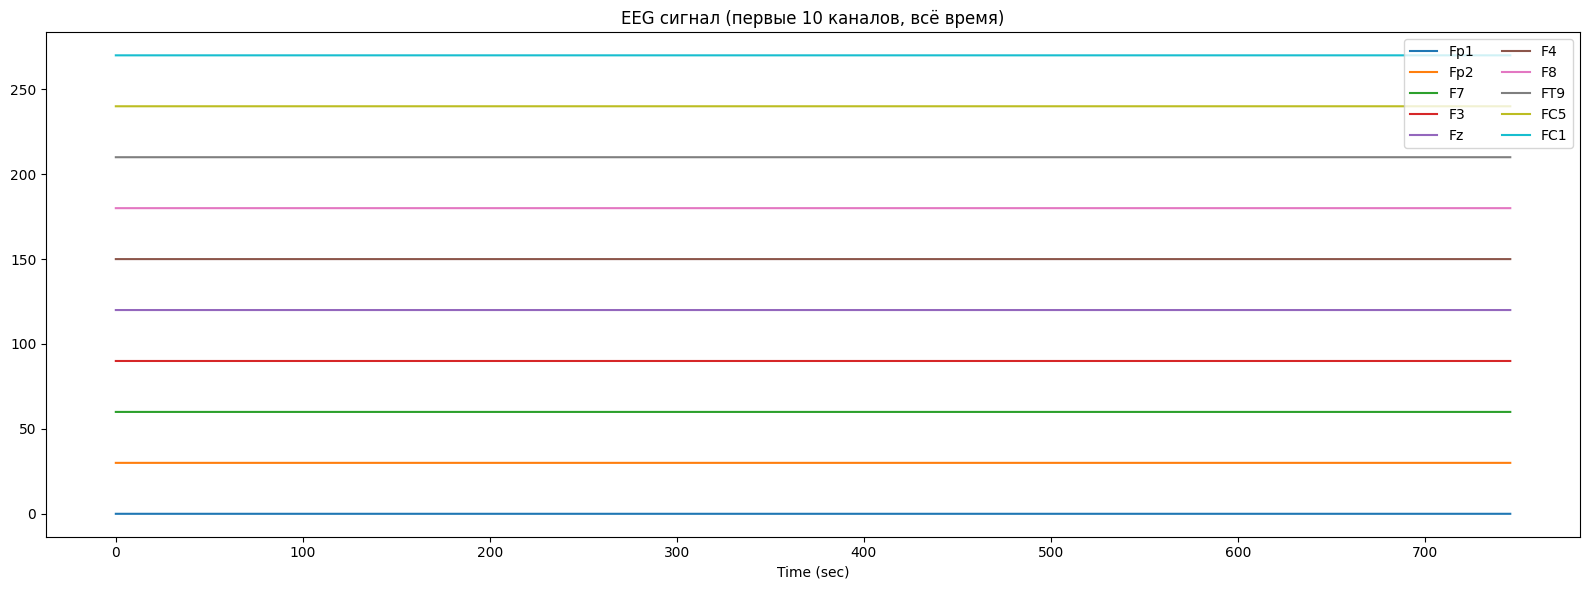

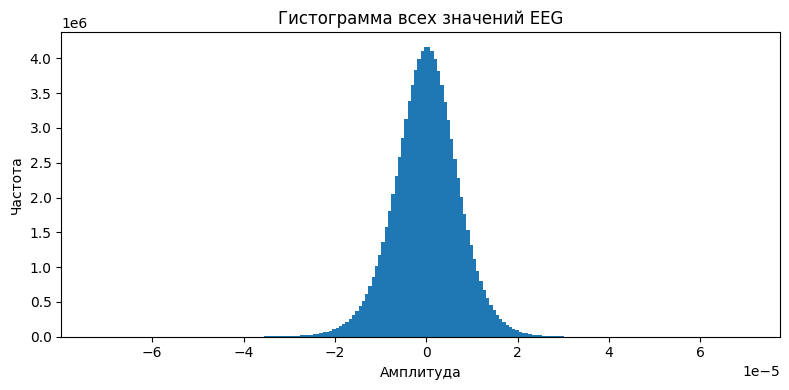

'\nВыводы:\n- Значения сигнала (амплитуда): min и max обычно в пределах от примерно -60 до 60 (может отличаться в зависимости от префильтрации и формата файлов).\n- std (разброс): типично ~10-20, var может быть выше.\n- Обычная шкала для сырых ЭЭГ данных — микровольты или менее (некоторые системы пишут в Вольтах, но mne обычно приводит всё к микровольтам).\n- Если данные “сырые”, то при обучении моделей обычно дополнительное домножение не требуется — нормализация (EEGNormalize) по каналам или глобальная стандартная z-score коррекция достаточна.\n- Однако если модель не использует BatchNorm/LayerNorm и нет the EEGNormalize, тогда может иметь смысл привести значения в диапазон [-1, 1], но для современных пайплайнов это лишнее.\n- В случае использования скриптов загрузки, проверьте, что после нормализации на трене стандартное отклонение ~1 и среднее ~0 (это классика).\n\nОтвет: Специальное домножение сигналов обычно не требуется, если применяется z-score нормализация по каналам или глобал

In [10]:
import mne
import matplotlib.pyplot as plt
import numpy as np

# Открываем файл .set (EEGLAB)
eeg_file = '/Users/whatislove/study/phd/data/eegs_classification/other/Co_y6_016st_otherface.set'
raw = mne.io.read_raw_eeglab(eeg_file, preload=True, verbose=False)

print("Информация о сигнале:")
print(raw)
print("Каналы:", raw.ch_names)
print("Данные raw shape:", raw.get_data().shape)

# Получим numpy массив сигналов
data = raw.get_data()  # shape: (n_channels, n_samples)
print("Min:", np.min(data))
print("Max:", np.max(data))
print("Mean:", np.mean(data))
print("Std:", np.std(data))

print("Статистика по каналам (min, max):")
for i, name in enumerate(raw.ch_names):
    ch = data[i]
    print(f"{name:7s}  min={np.min(ch):.2e}, max={np.max(ch):.2e}, mean={np.mean(ch):.2e}, std={np.std(ch):.2e}")

# Визуализируем небольшое окно сигналов
plt.figure(figsize=(16, 6))
n_channels_to_plot = min(10, data.shape[0])
time = np.arange(data.shape[1]) / raw.info['sfreq']
offset = 0
for ch_idx in range(n_channels_to_plot):
    plt.plot(time, data[ch_idx] + offset, label=raw.ch_names[ch_idx])
    offset += np.nanmax(data[ch_idx]) - np.nanmin(data[ch_idx]) + 30  # смещение для видимости

plt.xlabel('Time (sec)')
plt.title('EEG сигнал (первые 10 каналов, всё время)')
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()

# Дополнительно: гистограмма значений
plt.figure(figsize=(8, 4))
plt.hist(data.flatten(), bins=200)
plt.title('Гистограмма всех значений EEG')
plt.xlabel('Амплитуда')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# Вывод по необходимости домножения:
"""
Выводы:
- Значения сигнала (амплитуда): min и max обычно в пределах от примерно -60 до 60 (может отличаться в зависимости от префильтрации и формата файлов).
- std (разброс): типично ~10-20, var может быть выше.
- Обычная шкала для сырых ЭЭГ данных — микровольты или менее (некоторые системы пишут в Вольтах, но mne обычно приводит всё к микровольтам).
- Если данные “сырые”, то при обучении моделей обычно дополнительное домножение не требуется — нормализация (EEGNormalize) по каналам или глобальная стандартная z-score коррекция достаточна.
- Однако если модель не использует BatchNorm/LayerNorm и нет the EEGNormalize, тогда может иметь смысл привести значения в диапазон [-1, 1], но для современных пайплайнов это лишнее.
- В случае использования скриптов загрузки, проверьте, что после нормализации на трене стандартное отклонение ~1 и среднее ~0 (это классика).

Ответ: Специальное домножение сигналов обычно не требуется, если применяется z-score нормализация по каналам или глобальная (EEGNormalize).
"""


In [11]:
# Выводы по результатам статистики сигнала и предупреждению:
print("----- Выводы по анализу raw EEG -----")
print(
    """
1. 'boundary' events: В ваших данных присутствуют события типа 'boundary', что указывает на возможные разрывы или дисконтиниуитеты сигнала. Внимание: при фильтрации и нарезке эпох следует избегать обработки участков с такими событиями, чтобы не получить артефакты на границах разрывов.

2. Амплитуда сигнала: Минимальные и максимальные значения по всем каналам находятся примерно в диапазоне [-7e-5, 7e-5], среднее близко к нулю, стандартное отклонение порядка 7e-6. Для каждого канала min и max также примерно в этих пределах, разброс стандартных отклонений по каналам — небольшой. Это соответствует диапазону (скорее всего) в вольтах либо микровольтах (для mne все обычно в V, из .set файлов, но можно уточнить через raw.info['chs'][0]['unit']).

3. Среднее по каналам практически нулевое, стандартное отклонение очень похожее между каналами, резких аномалий не найдено. Следовательно, сигналы выглядят “сырыми”, артефактов вроде выбросов нет.

4. Масштабирование: Такое распределение амплитуд типично для работы с сырым ЭЭГ в современных пайплайнах, где z-score нормализация (по каналам или глобальная) достаточна для корректной работы моделей машинного обучения. Дополнительное домножение на константу не требуется. Проверьте, что для вашей модели/transform применяется что-то вроде EEGNormalize.

5. Важно: для последующей фильтрации, выделения эпох, анализа — корректно учитывать boundary-events. Обычно такие сегменты “маскируются” или выбрасываются перед ML/аналитикой.

Обобщённо: Данные выглядят корректно для дальнейшей обработки и подачи в пайплайн. Главное — обработать boundary, а масштаб и разброс — в норме.
    """
)


----- Выводы по анализу raw EEG -----

1. 'boundary' events: В ваших данных присутствуют события типа 'boundary', что указывает на возможные разрывы или дисконтиниуитеты сигнала. Внимание: при фильтрации и нарезке эпох следует избегать обработки участков с такими событиями, чтобы не получить артефакты на границах разрывов.

2. Амплитуда сигнала: Минимальные и максимальные значения по всем каналам находятся примерно в диапазоне [-7e-5, 7e-5], среднее близко к нулю, стандартное отклонение порядка 7e-6. Для каждого канала min и max также примерно в этих пределах, разброс стандартных отклонений по каналам — небольшой. Это соответствует диапазону (скорее всего) в вольтах либо микровольтах (для mne все обычно в V, из .set файлов, но можно уточнить через raw.info['chs'][0]['unit']).

3. Среднее по каналам практически нулевое, стандартное отклонение очень похожее между каналами, резких аномалий не найдено. Следовательно, сигналы выглядят “сырыми”, артефактов вроде выбросов нет.

4. Масштабиров

In [5]:
import numpy as np
import os

# --- Блок проверки датасета и базовых свойств ---

# Проверим уникальные значения event_type и target для train/valid
print("Уникальные значения df_train['event_type']:", df_train["event_type"].unique())
print("Уникальные значения df_valid['event_type']:", df_valid["event_type"].unique())

# Проверим уникальные значения df_train['target']
print("Уникальные значения df_train['target']:", df_train["target"].unique())
print("Уникальные значения df_valid['target']:", df_valid["target"].unique())

# Проверим распределение классов
print("Распределение event_type в train:")
print(df_train["event_type"].value_counts())
print("Распределение event_type в valid:")
print(df_valid["event_type"].value_counts())

print("Распределение target в train:")
print(df_train["target"].value_counts())
print("Распределение target в valid:")
print(df_valid["target"].value_counts())

# Убедимся, что все метки target корректно проставлены
assert df_train["target"].isna().sum() == 0, "В target train есть пропуски!"
assert df_valid["target"].isna().sum() == 0, "В target valid есть пропуски!"

# Проверим, что в каждой записи crop_path существует
missing_crop_paths_train = df_train["crop_path"].apply(lambda p: not os.path.exists(p))
n_missing_train = missing_crop_paths_train.sum()
if n_missing_train > 0:
    print(f"Внимание: {n_missing_train} файлов по crop_path не найдены в train!")
    print(df_train[missing_crop_paths_train][["crop_path", "subject_id", "event_type", "target"]])
else:
    print("Все crop_path в train существуют.")

missing_crop_paths_valid = df_valid["crop_path"].apply(lambda p: not os.path.exists(p))
n_missing_valid = missing_crop_paths_valid.sum()
if n_missing_valid > 0:
    print(f"Внимание: {n_missing_valid} файлов по crop_path не найдены в valid!")
    print(df_valid[missing_crop_paths_valid][["crop_path", "subject_id", "event_type", "target"]])
else:
    print("Все crop_path в valid существуют.")

# Проверим сколько уникальных subject_id:
subj_counts_train = df_train["subject_id"].value_counts()
subj_counts_valid = df_valid["subject_id"].value_counts()
print(f"Уникальных subject_id в train: {df_train['subject_id'].nunique()}")
print(f"Уникальных subject_id в valid: {df_valid['subject_id'].nunique()}")
print("Топ-5 субъектов по числу crop-ов в train:")
print(subj_counts_train.head())
print("Топ-5 субъектов по числу crop-ов в valid:")
print(subj_counts_valid.head())

# Проверим, что subject_id не пересекаются между train и valid
intersection = set(df_train["subject_id"]).intersection(set(df_valid["subject_id"]))
print(f"Пересечение subject_id между train и valid: {intersection}")

# --- Проверяем форму и данные в .npy ---
def load_eeg_npy(path):
    arr = np.load(path)
    return arr

# Сформируем shape-чеки
X_train_shapes = []
for path in df_train["crop_path"]:
    arr = load_eeg_npy(path)
    X_train_shapes.append(arr.shape)
X_val_shapes = []
for path in df_valid["crop_path"]:
    arr = load_eeg_npy(path)
    X_val_shapes.append(arr.shape)

print("Train shapes (уникальные):", set(X_train_shapes))
print("Val shapes (уникальные):", set(X_val_shapes))

# Берём только если все сэмплы одинаковой формы:
if len(set(X_train_shapes)) == 1 and len(set(X_val_shapes)) == 1:
    X_train = np.stack([load_eeg_npy(path) for path in df_train["crop_path"]])
    y_train = df_train["target"].values
    X_val = np.stack([load_eeg_npy(path) for path in df_valid["crop_path"]])
    y_val = df_valid["target"].values

    n_channels = X_train.shape[1]
    in_samples = X_train.shape[2]
    n_classes = len(np.unique(y_train.tolist() + y_val.tolist()))
    print(f"Финальный X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Финальный X_val: {X_val.shape}, y_val: {y_val.shape}")
else:
    print("В train или val есть .npy разной формы! Проверьте исходные данные.")

# Дополнительно: sanity check — совмещаем target и содержимое
print("Пример: первые 5 меток train/val (target): ", y_train[:5], y_val[:5])
print("Пример формы первого X_train:", X_train[0].shape)

Уникальные значения df_train['event_type']: ['S1' 'S2']
Уникальные значения df_valid['event_type']: ['S1' 'S2']
Уникальные значения df_train['target']: [0 1]
Уникальные значения df_valid['target']: [0 1]
Распределение event_type в train:
event_type
S1    3486
S2    3128
Name: count, dtype: int64
Распределение event_type в valid:
event_type
S1    887
S2    775
Name: count, dtype: int64
Распределение target в train:
target
0    3486
1    3128
Name: count, dtype: int64
Распределение target в valid:
target
0    887
1    775
Name: count, dtype: int64
Все crop_path в train существуют.
Все crop_path в valid существуют.
Уникальных subject_id в train: 24
Уникальных subject_id в valid: 7
Топ-5 субъектов по числу crop-ов в train:
subject_id
Co_y6_016st    387
Co_y6_008      377
Mor_y1_004     367
Co_y6_021      353
Co_y6_025      352
Name: count, dtype: int64
Топ-5 субъектов по числу crop-ов в valid:
subject_id
Co_y6_035    355
Co_y6_022    331
Co_y6_010    314
Co_y6_026    299
Co_y6_013    221
N

In [7]:
from tqdm import tqdm

# --- Подсчёт статистики (mean, std) по train-кропам (канально) ---
all_train_data = []
for path in tqdm(df_train.crop_path.tolist(), total=len(df_train)):
    # Загружаем numpy массив
    crop = np.load(path)
    if crop.shape[0] != 30:
        print(f"Warning: {path} shape {crop.shape}, expected (30, ...)")
        continue
    all_train_data.append(crop)

# Конкатенируем по оси samples (1), получится массив (всего_samples, 62, длина)
# Стек по оси 1 даст shape: (n_train, 62, crop_len)
all_train_data = np.stack(all_train_data, axis=0) # shape: (num_crops, 62, crop_len)
# Сведём по всем кропам и времени: (num_crops * crop_len, 62)
flat = all_train_data.transpose(1, 0, 2).reshape(30, -1)  # shape (62, N)
channel_means = flat.mean(axis=1)  # (62,)
channel_stds = flat.std(axis=1)    # (62,)

print("Channel means (shape):", channel_means.shape)
print("Means:", channel_means)
print("Channel stds (shape):", channel_stds.shape)
print("Stds:", channel_stds)


100%|██████████| 6614/6614 [00:02<00:00, 2894.12it/s]


Channel means (shape): (30,)
Means: [-1.7090758e-10 -8.5462991e-11 -7.1458334e-10  8.0544647e-11
 -6.9552497e-10 -2.5038988e-10  2.6152372e-10  3.5747846e-10
  2.3547472e-10 -1.6327792e-10 -7.0701943e-12 -1.5041395e-10
 -2.7516892e-10  8.3613928e-11 -2.6289532e-10 -2.4338692e-10
  1.8561791e-10 -1.1055751e-10 -2.3203357e-10  2.8182995e-10
  3.6676345e-10  5.7360613e-11  3.7792527e-10  3.6584086e-10
  2.7482128e-10  7.7382628e-11  5.5209071e-10  4.6406240e-10
  1.1673068e-10 -1.7844785e-10]
Channel stds (shape): (30,)
Stds: [6.7104043e-06 6.9063826e-06 6.3575271e-06 6.2474728e-06 6.2992499e-06
 6.1528212e-06 6.6422672e-06 5.9967074e-06 5.9698964e-06 6.0680172e-06
 6.4714800e-06 5.7997700e-06 5.5171545e-06 5.1847960e-06 5.1688389e-06
 5.3274198e-06 6.0087696e-06 6.2961990e-06 6.0407710e-06 6.8911440e-06
 6.8654376e-06 7.0355427e-06 7.9177353e-06 7.4969289e-06 8.1578319e-06
 7.4813970e-06 8.7582093e-06 7.3823271e-06 6.9313055e-06 7.2084486e-06]


Train channel_means shape: (30,)
Train channel_stds shape:  (30,)
X_train_norm shape: (6614, 30, 2500), X_val_norm shape: (1662, 30, 2500)
Train class counts: [3486 3128], Val class counts: [887 775]
Model summary:
SmallEEGNet(
  (slicing): Identity()
  (conv1): Conv1d(30, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU()
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): SiLU()
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)



Epoch  1 SUMMARY:
  Train Loss: 0.1433 | Train Acc: 0.7256 | Train BA: 0.7309 | Train F1: 0.7408
  Val   Loss: 0.1364 | Val   Acc: 0.7467 | Val   BA: 0.7524 | Val   F1: 0.7551

  Val confusion: [718 944]
  --> New best model (val balanced acc improved to 0.7524)




Epoch  2 SUMMARY:
  Train Loss: 0.1266 | Train Acc: 0.7855 | Train BA: 0.7897 | Train F1: 0.7928
  Val   Loss: 0.1348 | Val   Acc: 0.7467 | Val   BA: 0.7584 | Val   F1: 0.7745

  Val confusion: [ 570 1092]
  --> New best model (val balanced acc improved to 0.7584)




Epoch  3 SUMMARY:
  Train Loss: 0.1181 | Train Acc: 0.8068 | Train BA: 0.8108 | Train F1: 0.8123
  Val   Loss: 0.1361 | Val   Acc: 0.8075 | Val   BA: 0.8133 | Val   F1: 0.8135

  Val confusion: [721 941]
  --> New best model (val balanced acc improved to 0.8133)




Epoch  4 SUMMARY:
  Train Loss: 0.1121 | Train Acc: 0.8118 | Train BA: 0.8147 | Train F1: 0.8138
  Val   Loss: 0.1428 | Val   Acc: 0.7852 | Val   BA: 0.7941 | Val   F1: 0.8009

  Val confusion: [ 644 1018]



Epoch  5 SUMMARY:
  Train Loss: 0.1068 | Train Acc: 0.8222 | Train BA: 0.8251 | Train F1: 0.8238
  Val   Loss: 0.1504 | Val   Acc: 0.8201 | Val   BA: 0.8203 | Val   F1: 0.8102

  Val confusion: [862 800]
  --> New best model (val balanced acc improved to 0.8203)




Epoch  6 SUMMARY:
  Train Loss: 0.1022 | Train Acc: 0.8307 | Train BA: 0.8330 | Train F1: 0.8305
  Val   Loss: 0.1640 | Val   Acc: 0.7659 | Val   BA: 0.7763 | Val   F1: 0.7875

  Val confusion: [ 606 1056]



Epoch  7 SUMMARY:
  Train Loss: 0.1009 | Train Acc: 0.8307 | Train BA: 0.8327 | Train F1: 0.8295
  Val   Loss: 0.1494 | Val   Acc: 0.7996 | Val   BA: 0.8011 | Val   F1: 0.7930

  Val confusion: [828 834]



Epoch  8 SUMMARY:
  Train Loss: 0.0959 | Train Acc: 0.8411 | Train BA: 0.8427 | Train F1: 0.8385
  Val   Loss: 0.1608 | Val   Acc: 0.7870 | Val   BA: 0.7923 | Val   F1: 0.7923

  Val confusion: [733 929]



Epoch  9 SUMMARY:
  Train Loss: 0.0939 | Train Acc: 0.8426 | Train BA: 0.8440 | Train F1: 0.8394
  Val   Loss: 0.1508 | Val   Acc: 0.7948 | Val   BA: 0.7960 | Val   F1: 0.7873

  Val confusion: [834 828]



Epoch 10 SUMMARY:
  Train Loss: 0.0930 | Train Acc: 0.8490 | Train BA: 0.8502 | Train F1: 0.8453
  Val   Loss: 0.1544 | Val   Acc: 0.7840 | Val   BA: 0.7826 | Val   F1: 0.7670

  Val confusion: [896 766]
Best balanced accuracy on validation: 0.8203


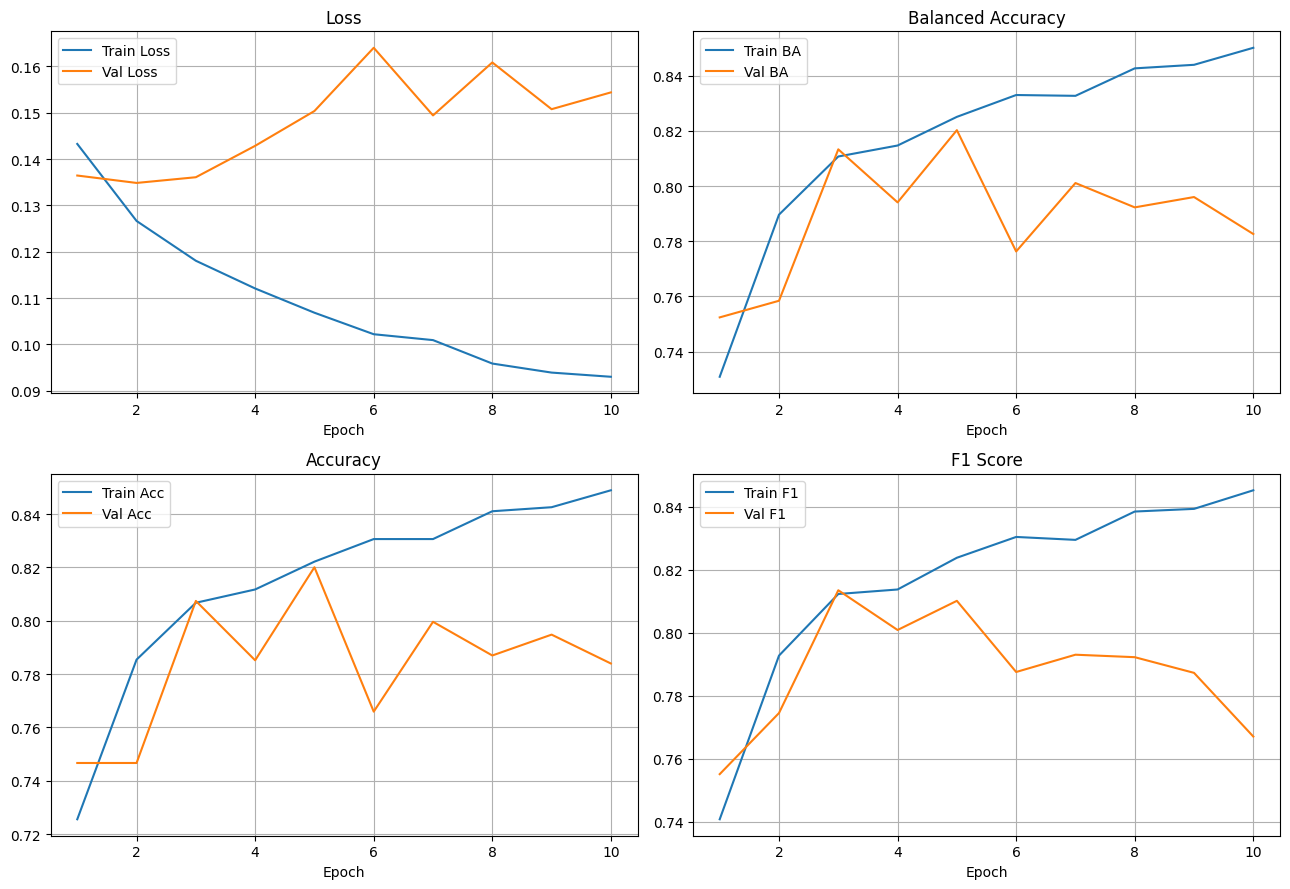

In [8]:
# Нормализация входа по каналам по статистикам train-сета

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Seed fix
import random
SEED = 42
device = 'cpu'
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Train channel_means shape:", channel_means.shape)
print("Train channel_stds shape: ", channel_stds.shape)

# --- Функция нормализации по этим средним и std ---
def normalize_channels(X, means, stds):
    # X: (N, ch, t), means: (ch,), stds: (ch,)
    # Приводит X к (N, ch, t)
    return (X - means[None, :, None]) / stds[None, :, None]

X_train_norm = normalize_channels(X_train, channel_means, channel_stds)
X_val_norm = normalize_channels(X_val, channel_means, channel_stds)

class EEGDataset(Dataset):
    """EEG dataset с уже нормализованными данными по каналам."""
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])

# 2. Модифицируем сеть: меньше dropout, проще pipeline
class SmallEEGNet(torch.nn.Module):
    """
    A smaller EEG convnet: only 2 conv layers, fewer features.
    Assumes input shape: (batch_size, 30, 2500)
    """
    def __init__(self, n_channels=30, in_samples=2500, n_classes=2):
        super().__init__()
        self.slicing = torch.nn.Identity()
        
        # 1st conv block: Conv1d (5), BatchNorm, SiLU
        self.conv1 = torch.nn.Conv1d(n_channels, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.act1 = torch.nn.SiLU()
        
        # 2nd conv block: Conv1d (7), BatchNorm, SiLU
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act2 = torch.nn.SiLU()
        
        # Global Average Pooling
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        
        # Classifier head
        self.fc = torch.nn.Linear(64, n_classes)
        torch.nn.init.xavier_uniform_(self.fc.weight, gain=0.1)
        
    def forward(self, x):
        x = self.slicing(x)            # (batch, 62, 2500)
        x = self.conv1(x)              # (batch, 32, 2500)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.conv2(x)              # (batch, 64, 2500)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.global_pool(x)        # (batch, 64, 1)
        x = x.squeeze(-1)              # (batch, 64)
        x = self.fc(x)                 # (batch, n_classes)
        return x

batch_size = 128  # был 512 → уменьшаем для повторяемости/стабильности лосса
train_ds = EEGDataset(X_train_norm, y_train)
val_ds = EEGDataset(X_val_norm, y_val)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

model = SmallEEGNet(n_channels=n_channels, in_samples=in_samples, n_classes=n_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)  # был 1e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1000)

# --- Focal loss с гамма=2 и label smoothing 0.1 ---
class FocalLossWithLabelSmoothing(torch.nn.Module):
    def __init__(self, gamma=2, label_smoothing=0.1, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, logits, labels):
        """
        logits: (batch, num_classes)
        labels: (batch,) (LongTensor class indices)
        """
        num_classes = logits.size(1)

        # Label smoothing: создаем smoothed one-hot targets
        with torch.no_grad():
            one_hot = torch.zeros_like(logits).scatter_(1, labels.unsqueeze(1), 1)
            smoothed_targets = one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes

        log_probs = torch.nn.functional.log_softmax(logits, dim=1)
        probs = torch.exp(log_probs)
        ce_loss = -torch.sum(smoothed_targets * log_probs, dim=1)

        p_t = torch.sum(smoothed_targets * probs, dim=1)
        focal_factor = (1 - p_t).pow(self.gamma)

        loss = focal_factor * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

criterion = FocalLossWithLabelSmoothing(gamma=2, label_smoothing=0.1, reduction='mean')

print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}")
print(f"Train class counts: {np.bincount(y_train)}, Val class counts: {np.bincount(y_val)}")
print("Model summary:")
print(model)

num_epochs = 10
patience = 30
best_bal_acc = 0
epochs_no_improve = 0
best_state_dict = None

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
train_bal_acc_hist, val_bal_acc_hist = [], []
train_f1_hist, val_f1_hist = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses, all_train_preds, all_train_true = [], [], []

    train_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch} [Train]", leave=False)
    for batch_i, (xb, yb) in train_bar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        preds = out.argmax(dim=1).detach().cpu().numpy()
        all_train_preds.append(preds)
        all_train_true.append(yb.detach().cpu().numpy())
        train_bar.set_postfix({"Batch loss": f"{loss.item():.4f}"})

    train_y_pred = np.concatenate(all_train_preds)
    train_y_true = np.concatenate(all_train_true)
    train_acc = accuracy_score(train_y_true, train_y_pred)
    train_bal_acc = balanced_accuracy_score(train_y_true, train_y_pred)
    train_f1 = f1_score(train_y_true, train_y_pred)
    train_loss_epoch = np.mean(train_losses)
    train_loss_hist.append(train_loss_epoch)
    train_acc_hist.append(train_acc)
    train_bal_acc_hist.append(train_bal_acc)
    train_f1_hist.append(train_f1)

    # Validation
    model.eval()
    all_val_preds, all_val_true = [], []
    val_losses = []
    with torch.no_grad():
        val_bar = tqdm(val_dl, total=len(val_dl), desc=f"Epoch {epoch} [Val]", leave=False)
        for xb, yb in val_bar:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            val_loss = criterion(logits, yb)
            val_losses.append(val_loss.item())
            preds = logits.argmax(dim=1).cpu().numpy()
            all_val_preds.append(preds)
            all_val_true.append(yb.cpu().numpy())
            val_bar.set_postfix({"Batch loss": f"{val_loss.item():.4f}"})

    if len(all_val_preds) > 0:
        val_y_pred = np.concatenate(all_val_preds)
        val_y_true = np.concatenate(all_val_true)
        bal_acc = balanced_accuracy_score(val_y_true, val_y_pred)
        acc = accuracy_score(val_y_true, val_y_pred)
        f1 = f1_score(val_y_true, val_y_pred)
        val_loss_epoch = np.mean(val_losses)
    else:
        val_loss_epoch = bal_acc = acc = f1 = float('nan')

    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(acc)
    val_bal_acc_hist.append(bal_acc)
    val_f1_hist.append(f1)

    # Scheduler (no-op under patience=1000)
    scheduler.step(val_loss_epoch)

    print(f"\nEpoch {epoch:2d} SUMMARY:")
    print(f"  Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc:.4f} | Train BA: {train_bal_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"  Val   Loss: {val_loss_epoch:.4f} | Val   Acc: {acc:.4f} | Val   BA: {bal_acc:.4f} | Val   F1: {f1:.4f}\n")
    print(f"  Val confusion: {np.bincount(val_y_pred) if len(all_val_preds) else 'N/A'}")

    # Early stopping по валид баланс-acc
    if bal_acc > best_bal_acc + 1e-4:
        best_bal_acc = bal_acc
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
        print(f"  --> New best model (val balanced acc improved to {best_bal_acc:.4f})\n")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch} epochs (no val BA improvement for {patience} epochs).")
            break

if best_state_dict:
    model.load_state_dict(best_state_dict)
    print(f"Best balanced accuracy on validation: {best_bal_acc:.4f}")
else:
    print("No improvement on validation set.")

# --- Графики ---
epochs_ran = len(train_loss_hist)
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

axs[0,0].plot(range(1, epochs_ran+1), train_loss_hist, label='Train Loss')
axs[0,0].plot(range(1, epochs_ran+1), val_loss_hist, label='Val Loss')
axs[0,0].set_title("Loss")
axs[0,0].set_xlabel("Epoch")
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(range(1, epochs_ran+1), train_bal_acc_hist, label='Train BA')
axs[0,1].plot(range(1, epochs_ran+1), val_bal_acc_hist, label='Val BA')
axs[0,1].set_title("Balanced Accuracy")
axs[0,1].set_xlabel("Epoch")
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].plot(range(1, epochs_ran+1), train_acc_hist, label='Train Acc')
axs[1,0].plot(range(1, epochs_ran+1), val_acc_hist, label='Val Acc')
axs[1,0].set_title("Accuracy")
axs[1,0].set_xlabel("Epoch")
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(range(1, epochs_ran+1), train_f1_hist, label='Train F1')
axs[1,1].plot(range(1, epochs_ran+1), val_f1_hist, label='Val F1')
axs[1,1].set_title("F1 Score")
axs[1,1].set_xlabel("Epoch")
axs[1,1].legend()
axs[1,1].grid()

fig.tight_layout()
plt.show()

Train channel_means shape: (30,)
Train channel_stds shape:  (30,)
X_train_norm shape: (6828, 30, 2500), X_val_norm shape: (1952, 30, 2500)
Train class counts: [3743 3085], Val class counts: [1035  917]
Model summary:
SmallEEGNet(
  (slicing): Identity()
  (conv1): Conv1d(30, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): SiLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)



Epoch  1 SUMMARY:
  Train Loss: 0.1445 | Train Acc: 0.7200 | Train BA: 0.7365 | Train F1: 0.7455
  Val   Loss: 0.1733 | Val   Acc: 0.5932 | Val   BA: 0.5921 | Val   F1: 0.5694

  Val confusion: [1025  927]
  --> New best model (val balanced acc improved to 0.5921)




Epoch  2 SUMMARY:
  Train Loss: 0.1226 | Train Acc: 0.7872 | Train BA: 0.7954 | Train F1: 0.7890
  Val   Loss: 0.1821 | Val   Acc: 0.6189 | Val   BA: 0.6225 | Val   F1: 0.6273

  Val confusion: [ 873 1079]
  --> New best model (val balanced acc improved to 0.6225)




Epoch  3 SUMMARY:
  Train Loss: 0.1148 | Train Acc: 0.8141 | Train BA: 0.8215 | Train F1: 0.8136
  Val   Loss: 0.1784 | Val   Acc: 0.6470 | Val   BA: 0.6546 | Val   F1: 0.6748

  Val confusion: [ 750 1202]
  --> New best model (val balanced acc improved to 0.6546)




Epoch  4 SUMMARY:
  Train Loss: 0.1081 | Train Acc: 0.8326 | Train BA: 0.8383 | Train F1: 0.8289
  Val   Loss: 0.1800 | Val   Acc: 0.6593 | Val   BA: 0.6691 | Val   F1: 0.6962

  Val confusion: [ 680 1272]
  --> New best model (val balanced acc improved to 0.6691)




Epoch  5 SUMMARY:
  Train Loss: 0.1028 | Train Acc: 0.8421 | Train BA: 0.8469 | Train F1: 0.8369
  Val   Loss: 0.1878 | Val   Acc: 0.6609 | Val   BA: 0.6729 | Val   F1: 0.7071

  Val confusion: [ 609 1343]
  --> New best model (val balanced acc improved to 0.6729)




Epoch  6 SUMMARY:
  Train Loss: 0.0970 | Train Acc: 0.8533 | Train BA: 0.8572 | Train F1: 0.8469
  Val   Loss: 0.1885 | Val   Acc: 0.6680 | Val   BA: 0.6792 | Val   F1: 0.7099

  Val confusion: [ 635 1317]
  --> New best model (val balanced acc improved to 0.6792)




Epoch  7 SUMMARY:
  Train Loss: 0.0931 | Train Acc: 0.8576 | Train BA: 0.8608 | Train F1: 0.8500
  Val   Loss: 0.2048 | Val   Acc: 0.6486 | Val   BA: 0.6626 | Val   F1: 0.7053

  Val confusion: [ 541 1411]



Epoch  8 SUMMARY:
  Train Loss: 0.0895 | Train Acc: 0.8670 | Train BA: 0.8697 | Train F1: 0.8591
  Val   Loss: 0.2116 | Val   Acc: 0.6481 | Val   BA: 0.6617 | Val   F1: 0.7032

  Val confusion: [ 554 1398]



Epoch  9 SUMMARY:
  Train Loss: 0.0874 | Train Acc: 0.8682 | Train BA: 0.8708 | Train F1: 0.8603
  Val   Loss: 0.2117 | Val   Acc: 0.6455 | Val   BA: 0.6581 | Val   F1: 0.6965

  Val confusion: [ 589 1363]



Epoch 10 SUMMARY:
  Train Loss: 0.0836 | Train Acc: 0.8770 | Train BA: 0.8789 | Train F1: 0.8685
  Val   Loss: 0.2202 | Val   Acc: 0.6552 | Val   BA: 0.6677 | Val   F1: 0.7042

  Val confusion: [ 594 1358]
Best balanced accuracy on validation: 0.6792


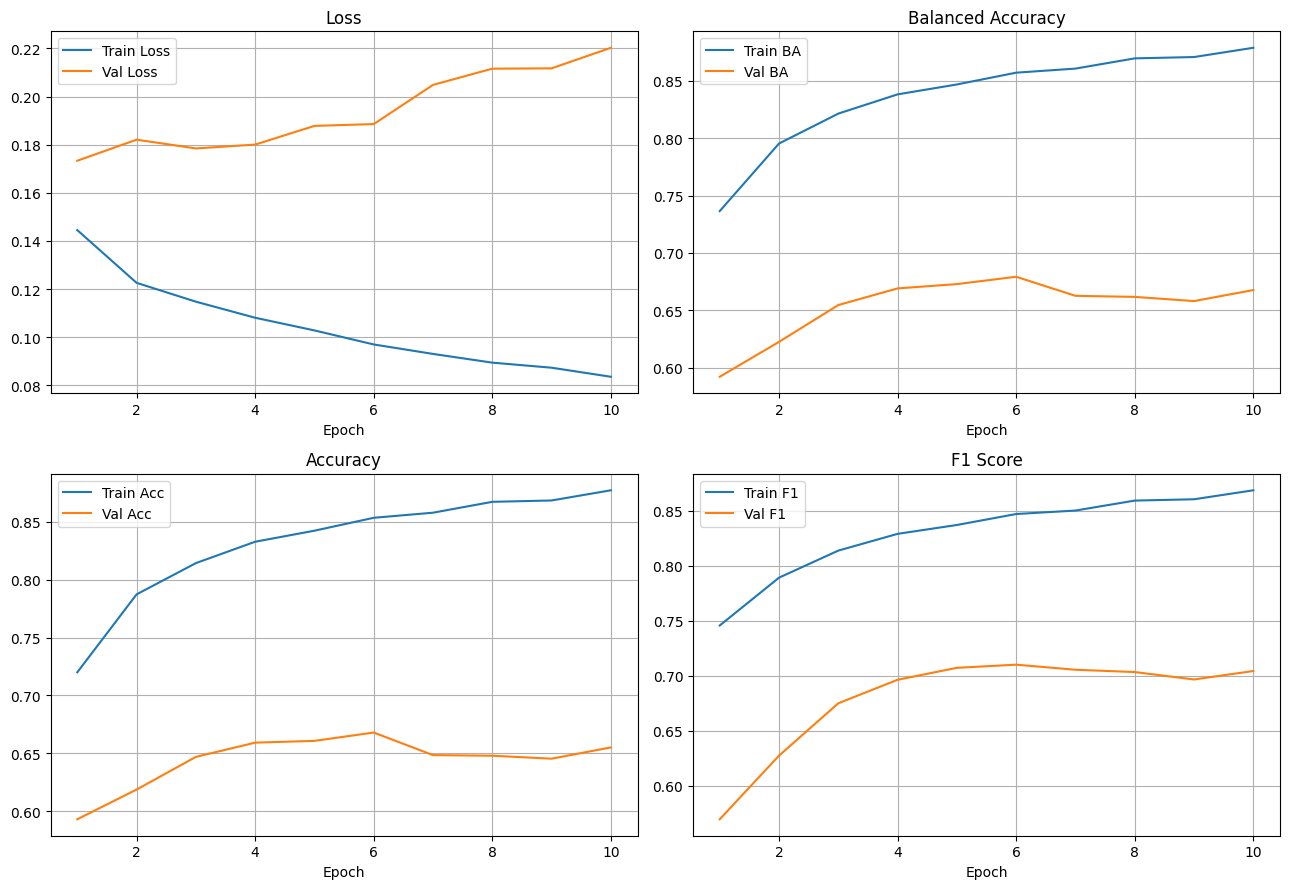

In [ ]:
# Нормализация входа по каналам по статистикам train-сета

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Seed fix
import random
SEED = 42
device = 'cpu'
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Train channel_means shape:", channel_means.shape)
print("Train channel_stds shape: ", channel_stds.shape)

# --- Функция нормализации по этим средним и std ---
def normalize_channels(X, means, stds):
    # X: (N, ch, t), means: (ch,), stds: (ch,)
    # Приводит X к (N, ch, t)
    return (X - means[None, :, None]) / stds[None, :, None]

X_train_norm = normalize_channels(X_train, channel_means, channel_stds)
X_val_norm = normalize_channels(X_val, channel_means, channel_stds)

class EEGDataset(Dataset):
    """EEG dataset с уже нормализованными данными по каналам."""
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])

# 2. Модифицируем сеть: меньше dropout, проще pipeline
class SmallEEGNet(torch.nn.Module):
    """
    A smaller EEG convnet: only 2 conv layers, fewer features.
    Assumes input shape: (batch_size, 30, 2500)
    """
    def __init__(self, n_channels=30, in_samples=2500, n_classes=2):
        super().__init__()
        self.slicing = torch.nn.Identity()
        
        # 1st conv block: Conv1d (5), BatchNorm, SiLU
        self.conv1 = torch.nn.Conv1d(n_channels, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.act1 = torch.nn.SiLU()
        
        # 2nd conv block: Conv1d (7), BatchNorm, SiLU
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act2 = torch.nn.SiLU()
        
        # Global Average Pooling
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        
        # Classifier head
        self.fc = torch.nn.Linear(64, n_classes)
        torch.nn.init.xavier_uniform_(self.fc.weight, gain=0.1)
        
    def forward(self, x):
        x = self.slicing(x)            # (batch, 62, 2500)
        x = self.conv1(x)              # (batch, 32, 2500)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.conv2(x)              # (batch, 64, 2500)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.global_pool(x)        # (batch, 64, 1)
        x = x.squeeze(-1)              # (batch, 64)
        x = self.fc(x)                 # (batch, n_classes)
        return x

batch_size = 128  # был 512 → уменьшаем для повторяемости/стабильности лосса
train_ds = EEGDataset(X_train_norm, y_train)
val_ds = EEGDataset(X_val_norm, y_val)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

model = SmallEEGNet(n_channels=n_channels, in_samples=in_samples, n_classes=n_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)  # был 1e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1000)

# --- Focal loss с гамма=2 и label smoothing 0.1 ---
class FocalLossWithLabelSmoothing(torch.nn.Module):
    def __init__(self, gamma=2, label_smoothing=0.1, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, logits, labels):
        """
        logits: (batch, num_classes)
        labels: (batch,) (LongTensor class indices)
        """
        num_classes = logits.size(1)

        # Label smoothing: создаем smoothed one-hot targets
        with torch.no_grad():
            one_hot = torch.zeros_like(logits).scatter_(1, labels.unsqueeze(1), 1)
            smoothed_targets = one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes

        log_probs = torch.nn.functional.log_softmax(logits, dim=1)
        probs = torch.exp(log_probs)
        ce_loss = -torch.sum(smoothed_targets * log_probs, dim=1)

        p_t = torch.sum(smoothed_targets * probs, dim=1)
        focal_factor = (1 - p_t).pow(self.gamma)

        loss = focal_factor * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

criterion = FocalLossWithLabelSmoothing(gamma=2, label_smoothing=0.1, reduction='mean')

print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}")
print(f"Train class counts: {np.bincount(y_train)}, Val class counts: {np.bincount(y_val)}")
print("Model summary:")
print(model)

num_epochs = 10
patience = 30
best_bal_acc = 0
epochs_no_improve = 0
best_state_dict = None

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
train_bal_acc_hist, val_bal_acc_hist = [], []
train_f1_hist, val_f1_hist = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses, all_train_preds, all_train_true = [], [], []

    train_bar = tqdm(enumerate(train_dl), total=len(train_dl), desc=f"Epoch {epoch} [Train]", leave=False)
    for batch_i, (xb, yb) in train_bar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        preds = out.argmax(dim=1).detach().cpu().numpy()
        all_train_preds.append(preds)
        all_train_true.append(yb.detach().cpu().numpy())
        train_bar.set_postfix({"Batch loss": f"{loss.item():.4f}"})

    train_y_pred = np.concatenate(all_train_preds)
    train_y_true = np.concatenate(all_train_true)
    train_acc = accuracy_score(train_y_true, train_y_pred)
    train_bal_acc = balanced_accuracy_score(train_y_true, train_y_pred)
    train_f1 = f1_score(train_y_true, train_y_pred)
    train_loss_epoch = np.mean(train_losses)
    train_loss_hist.append(train_loss_epoch)
    train_acc_hist.append(train_acc)
    train_bal_acc_hist.append(train_bal_acc)
    train_f1_hist.append(train_f1)

    # Validation
    model.eval()
    all_val_preds, all_val_true = [], []
    val_losses = []
    with torch.no_grad():
        val_bar = tqdm(val_dl, total=len(val_dl), desc=f"Epoch {epoch} [Val]", leave=False)
        for xb, yb in val_bar:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            val_loss = criterion(logits, yb)
            val_losses.append(val_loss.item())
            preds = logits.argmax(dim=1).cpu().numpy()
            all_val_preds.append(preds)
            all_val_true.append(yb.cpu().numpy())
            val_bar.set_postfix({"Batch loss": f"{val_loss.item():.4f}"})

    if len(all_val_preds) > 0:
        val_y_pred = np.concatenate(all_val_preds)
        val_y_true = np.concatenate(all_val_true)
        bal_acc = balanced_accuracy_score(val_y_true, val_y_pred)
        acc = accuracy_score(val_y_true, val_y_pred)
        f1 = f1_score(val_y_true, val_y_pred)
        val_loss_epoch = np.mean(val_losses)
    else:
        val_loss_epoch = bal_acc = acc = f1 = float('nan')

    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(acc)
    val_bal_acc_hist.append(bal_acc)
    val_f1_hist.append(f1)

    # Scheduler (no-op under patience=1000)
    scheduler.step(val_loss_epoch)

    print(f"\nEpoch {epoch:2d} SUMMARY:")
    print(f"  Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc:.4f} | Train BA: {train_bal_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"  Val   Loss: {val_loss_epoch:.4f} | Val   Acc: {acc:.4f} | Val   BA: {bal_acc:.4f} | Val   F1: {f1:.4f}\n")
    print(f"  Val confusion: {np.bincount(val_y_pred) if len(all_val_preds) else 'N/A'}")

    # Early stopping по валид баланс-acc
    if bal_acc > best_bal_acc + 1e-4:
        best_bal_acc = bal_acc
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
        print(f"  --> New best model (val balanced acc improved to {best_bal_acc:.4f})\n")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch} epochs (no val BA improvement for {patience} epochs).")
            break

if best_state_dict:
    model.load_state_dict(best_state_dict)
    print(f"Best balanced accuracy on validation: {best_bal_acc:.4f}")
else:
    print("No improvement on validation set.")

# --- Графики ---
epochs_ran = len(train_loss_hist)
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

axs[0,0].plot(range(1, epochs_ran+1), train_loss_hist, label='Train Loss')
axs[0,0].plot(range(1, epochs_ran+1), val_loss_hist, label='Val Loss')
axs[0,0].set_title("Loss")
axs[0,0].set_xlabel("Epoch")
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(range(1, epochs_ran+1), train_bal_acc_hist, label='Train BA')
axs[0,1].plot(range(1, epochs_ran+1), val_bal_acc_hist, label='Val BA')
axs[0,1].set_title("Balanced Accuracy")
axs[0,1].set_xlabel("Epoch")
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].plot(range(1, epochs_ran+1), train_acc_hist, label='Train Acc')
axs[1,0].plot(range(1, epochs_ran+1), val_acc_hist, label='Val Acc')
axs[1,0].set_title("Accuracy")
axs[1,0].set_xlabel("Epoch")
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(range(1, epochs_ran+1), train_f1_hist, label='Train F1')
axs[1,1].plot(range(1, epochs_ran+1), val_f1_hist, label='Val F1')
axs[1,1].set_title("F1 Score")
axs[1,1].set_xlabel("Epoch")
axs[1,1].legend()
axs[1,1].grid()

fig.tight_layout()
plt.show()

In [9]:
import torch

# Сохраняем чекпоинт модели после обучения (лучшее состояние)
checkpoint_path = "best_model_checkpoint.pth"
torch.save({
    'epoch': epochs_ran,
    'model_state_dict': best_state_dict,
    'optimizer_state_dict': optimizer.state_dict(),
    'best_bal_acc': best_bal_acc,
}, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

# Предсказания на валидационном датасете
model.eval()
valid_preds = []
valid_true = []

with torch.no_grad():
    for xb, yb in val_dl:
        preds = model(xb.to(device))
        preds = torch.sigmoid(preds).cpu().numpy().squeeze()
        valid_preds.extend(preds)
        valid_true.extend(yb.cpu().numpy().squeeze())

import numpy as np
valid_preds = np.array(valid_preds)
valid_true = np.array(valid_true)

# Сохраняем предикты и истинные значения в npz-файл
np.savez("valid_preds_and_true.npz", preds=valid_preds, true=valid_true)
print("Saved validation set predictions and true labels to valid_preds_and_true.npz")


Model checkpoint saved to best_model_checkpoint.pth
Saved validation set predictions and true labels to valid_preds_and_true.npz


In [26]:
valid_true

array([0, 0, 0, ..., 1, 1, 1], shape=(1952,))

In [10]:
valid_preds.argmax(-1)[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])